In [19]:
import numpy as np
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from scipy.special import lpmv

In [48]:
a = 1.0        # параметр потенциала
m = 5          # число связанных состояний
U0 = m * (m + 1) * a**2   # коэффициент потенциала
l = 10.0 / a    # граница области |x| < l
N = 1200       # число узлов сетки
num_modes = 5  # сколько собственных состояний ищем

x = np.linspace(-l, l, N)
h = x[1] - x[0]



**Начальное уравнение**  

- $\frac{d^2 \psi(x)}{dx^2} + U(x)\psi(x) = E \psi(x)$


**Аппроксимация второй производной** — *центральная разностная схема второго порядка точности*  

$\frac{d^2\psi}{dx^2} \approx \frac{\psi_{i-1} - 2\psi_i + \psi_{i+1}}{h^2}$


**Матрица оператора Гамильтониана H**  
$$
H = \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & 0 & \dots \\
-1 & 2 & -1 & \dots \\
0 & -1 & 2 & \dots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}
+ 
\mathrm{diag}(U(x_1), U(x_2), \dots, U(x_N))
$$
Главная диагональ содержит **2**, соседние — **−1**.  



**Уравнение, которое решаем**  
$H \Psi = E \Psi$

где  
$ \Psi = (\psi_1, \psi_2, ..., \psi_N) $ — дискретная форма волновой функции,  
E — собственное значение (энергия).  

**Уравнения, решаемые в методе Релея**  
Итерационно:
$$
(H - \lambda_k I) v_{k+1} = v_k,
\quad
\lambda_{k+1} = \frac{v_{k+1}^T H v_{k+1}}{v_{k+1}^T v_{k+1}},
\quad
v_{k+1} \leftarrow \frac{v_{k+1}}{\|v_{k+1}\|}
$$
Метод уточняет приближения $v_k$ (волновую функцию) и $\lambda_k$ (энергию) до сходимости.


In [49]:
# Матрица Лапласиана
main_diag = 2 * np.ones(N)
off_diag = -1 * np.ones(N - 1)
L = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
L /= h**2

# Потенциал
U = U0 * np.tanh(a * x)**2
H = L + np.diag(U)

# Зануляем только правую границу: ψ(l) = 0
H = H[:-1, :-1]    # удаляем последнюю строку и столбец
x_inner = x[:-1]   # оставляем сетку без последней точки


In [50]:
def rayleigh_iteration(A, v0, lam_initial, tol=1e-10, max_iter=1000):
    v = v0 / norm(v0)
    lam = lam_initial
    for _ in range(max_iter):
        v_new = solve(A - lam * np.eye(A.shape[0]), v)
        v_new /= norm(v_new)
        lam_new = (v_new @ (A @ v_new)) / (v_new @ v_new)
        if norm(v_new - v) < tol or norm(v_new + v) < tol:
            return lam_new, v_new
        v = v_new
        lam = lam_new
    return lam, v

In [51]:
# Поиск СЗ и СВ
analytical_E = [U0 - (a * (m - k))**2 for k in range(num_modes)]
print("Аналитические уровни энергии:", analytical_E)

eigvals = []
eigvecs = []

for n in range(num_modes):
    v0 = np.random.rand(N-1)
    lam, vec = rayleigh_iteration(H, v0, lam_initial=analytical_E[n])
    eigvals.append(lam)
    eigvecs.append(vec / norm(vec))

Аналитические уровни энергии: [5.0, 14.0, 21.0, 26.0, 29.0]


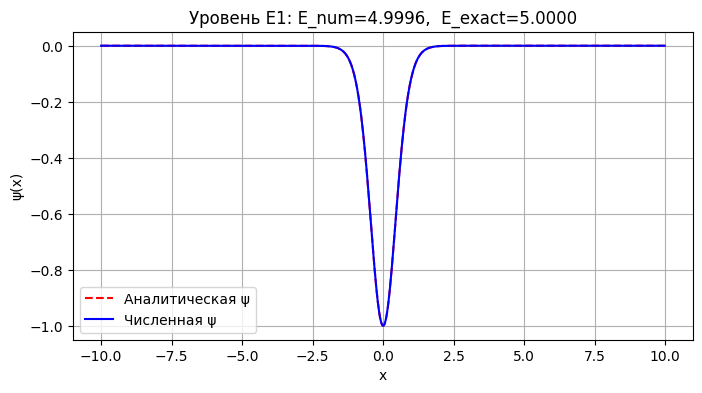

Собственное значение 1: E_num=4.999615, E_exact=5.000000
Относительная ошибка волновой функции: 0.01%



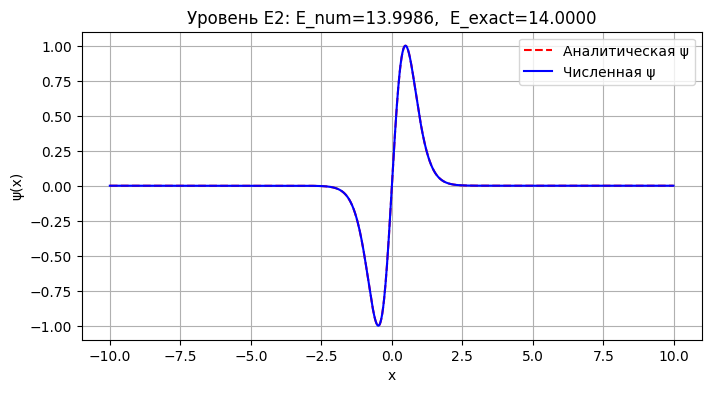

Собственное значение 2: E_num=13.998578, E_exact=14.000000
Относительная ошибка волновой функции: 0.02%



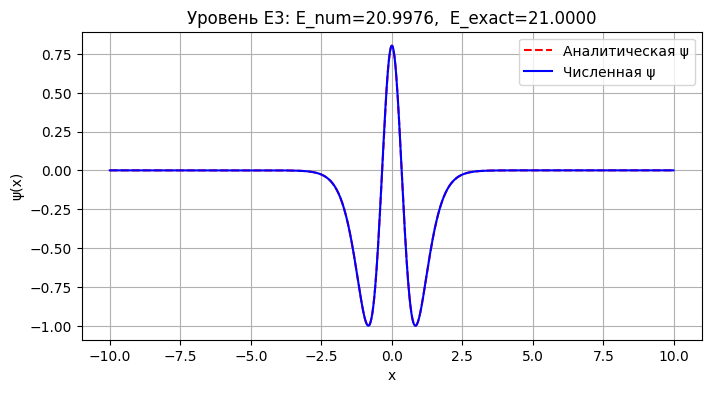

Собственное значение 3: E_num=20.997557, E_exact=21.000000
Относительная ошибка волновой функции: 0.03%



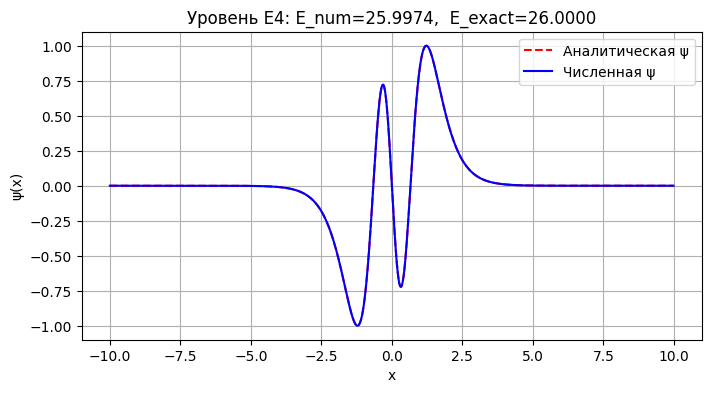

Собственное значение 4: E_num=25.997370, E_exact=26.000000
Относительная ошибка волновой функции: 0.06%



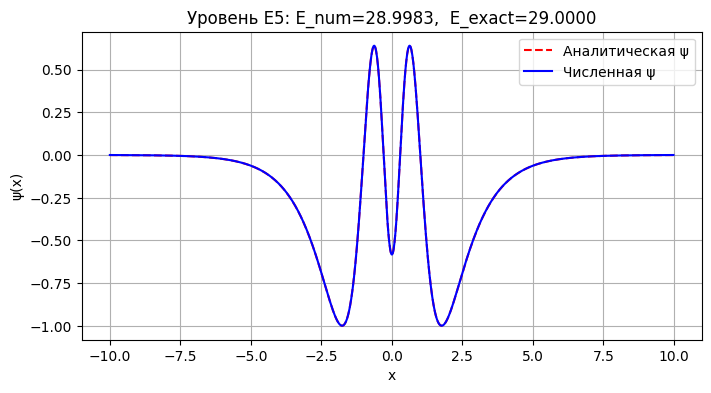

Собственное значение 5: E_num=28.998283, E_exact=29.000000
Относительная ошибка волновой функции: 0.09%



In [52]:
for k in range(num_modes):
    psi_num = eigvecs[k]
    psi_num /= np.max(np.abs(psi_num))
    
    # Аналитическая функция: P_m^{m-k}(tanh(ax))
    psi_analytical = lpmv(m - k, m, np.tanh(a * x_inner))
    psi_analytical /= np.max(np.abs(psi_analytical))
    
    # Коррекция знака
    sign = np.sign(np.dot(psi_num, psi_analytical))
    psi_num *= sign
    
    plt.figure(figsize=(8,4))
    plt.plot(x_inner, psi_analytical, 'r--', label='Аналитическая ψ')
    plt.plot(x_inner, psi_num, 'b', label='Численная ψ')
    plt.title(f"Уровень E{k+1}: E_num={eigvals[k]:.4f},  E_exact={analytical_E[k]:.4f}")
    plt.xlabel("x")
    plt.ylabel("ψ(x)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    err = norm(psi_num - psi_analytical) / norm(psi_analytical)
    print(f"Собственное значение {k+1}: E_num={eigvals[k]:.6f}, E_exact={analytical_E[k]:.6f}")
    print(f"Относительная ошибка волновой функции: {err*100:.2f}%\n")